<a href="https://colab.research.google.com/github/uts-strykers/braintumourdetection/blob/STRYK-5-Model-Training/Assignment2_BrainTumourDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3: Brain Tumour Detection
## Team: Strykers
*   Sotero Jr Saberon
*   Leon Ambrose Lusbo
*   Norah Albaqami






The following methods are used:

* Used a pretrained <b>Mask R-CNN with ResNeXt-101-32x8d for Feature Pyramid Network</b> from detectron2 [1,2]
* Modified the official notebook [3]
* Used validation and test sets for testing,

## Dataset information
TumorSegmentation
===================================================================

This dataset was exported via roboflow.com on August 19, 2023

The dataset includes 2146 images.
Tumors are annotated in COCO Segmentation format.
====================================================================

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)
* No image augmentation techniques were applied.
====================================================================

Provided by Roboflow
License: CC BY 4.0


## References
1. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
2. https://detectron2.readthedocs.io/en/latest/
3. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

#Step 1: Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Step 2: Import Libraries

In [ ]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [ ]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 99
THRESHOLD = 0.6

detectron2 version: 0.6


# Step 3: Data Collection/Ingestion

In [ ]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

#for d in ["train", "valid","test"]:
#    register_coco_instances(f"brain_tumor_{d}", {},
#                            f"../input/brain-tumor-image-dataset-semantic-segmentation/{d}/_annotations.coco.json",
#                            f"../input/brain-tumor-image-dataset-semantic-segmentation/{d}")

for d in ["train", "valid","test"]:
    register_coco_instances(f"brain_tumor_{d}", {},
                            f"/content/drive/MyDrive/Brain Tumor Detection Dataset/Dataset/{d}/_annotations.coco.json",
                            f"/content/drive/MyDrive/Brain Tumor Detection Dataset/Dataset/{d}")

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("brain_tumor_train")
train_dataset_dicts = DatasetCatalog.get("brain_tumor_train")

# Creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[03/27 08:18:07 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Brain Tumor Detection Dataset/Dataset/train/_annotations.coco.json takes 11.94 seconds.
WARNING [03/27 08:18:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/27 08:18:07 d2.data.datasets.coco]: Loaded 1502 images in COCO format from /content/drive/MyDrive/Brain Tumor Detection Dataset/Dataset/train/_annotations.coco.json


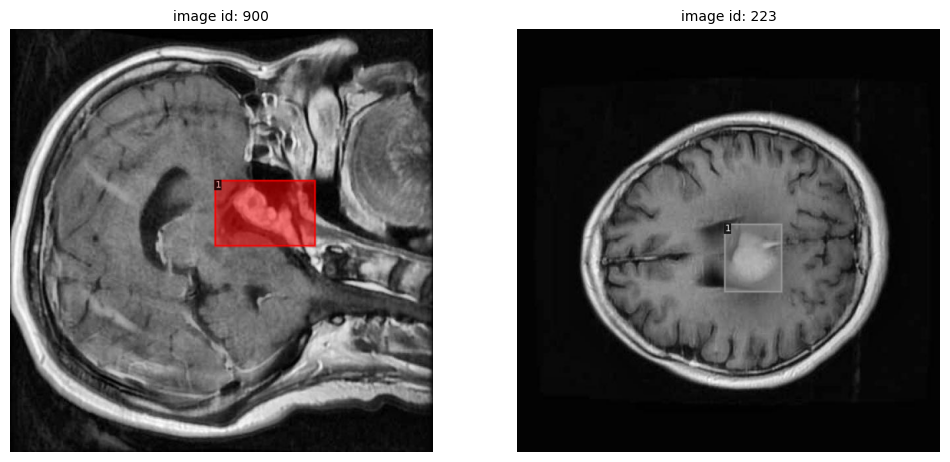

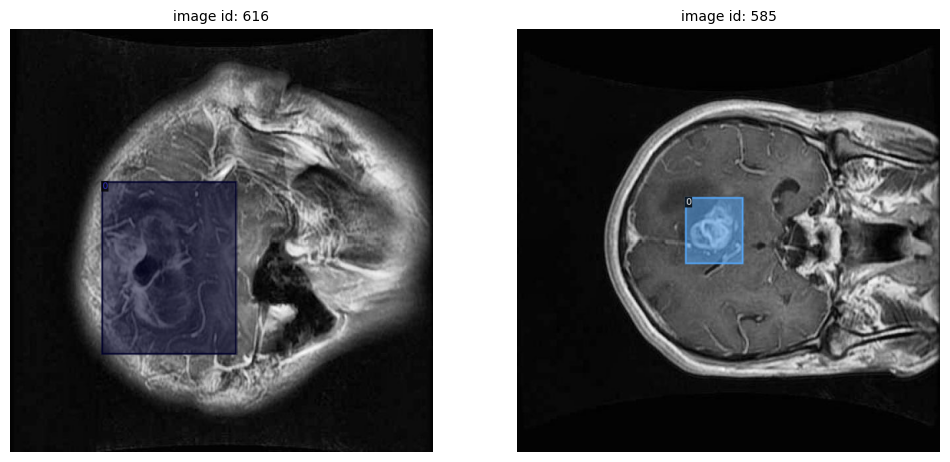

In [ ]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 95, image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 99, image_scale = 1)

# Step 4: Model Training

## Load Config

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 3300
NUM_CLASSES = 3
BASE_LR = 0.0001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("brain_tumor_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES




In [ ]:
print(cfg.OUTPUT_DIR)
%pwd

In [ ]:
#cfg = get_cfg()
# Load the previously saved cfg from file
cfg.merge_from_file(os.path.join('/content/drive/MyDrive/42174/brain-tumour-detector',"config.yaml"))


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
#trainer.train()

## Save the Config

In [ ]:
#from detectron2.config import get_cfg
import yaml

#cfg = get_cfg()
# ... configure your cfg as needed ...

# Save to a file
cfg_file_path = os.path.join(cfg.OUTPUT_DIR,"config.yaml")

cfg_file_path = os.path.join('/content/drive/MyDrive/42174/brain-tumour-detector','config.yaml')

print(cfg_file_path)

with open(cfg_file_path, 'w') as f:
    # The cfg object can be converted to a YAML string.
    f.write(cfg.dump())

## Save the Model

In [ ]:

#from detectron2.engine import DefaultTrainer
#from detectron2.config import get_cfg
from detectron2.checkpoint import Checkpointer

# After setting up your config and creating a DefaultTrainer
#trainer = DefaultTrainer(cfg)
#trainer.resume_or_load(resume=False)
#trainer.train()

# Create a Checkpointer and save the model
checkpointer = Checkpointer(trainer.model, save_dir="output")
checkpointer.save("model_final")  # This saves the model to output/model_final.pth


In [ ]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

# Step 7: Display Training Results

In [ ]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass
    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/content/output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
loss_mask = metric(train_metrics, 'loss_mask')
loss_box_reg = metric(train_metrics, 'loss_box_reg')


# checking metric lengths
if len(iters) == len(total_loss) == len(cls_acc) == len(loss_mask) == len(loss_box_reg):
    pass
else:
    iters = iters[:-1]

Text(0.5, 1.0, 'Mask Loss')

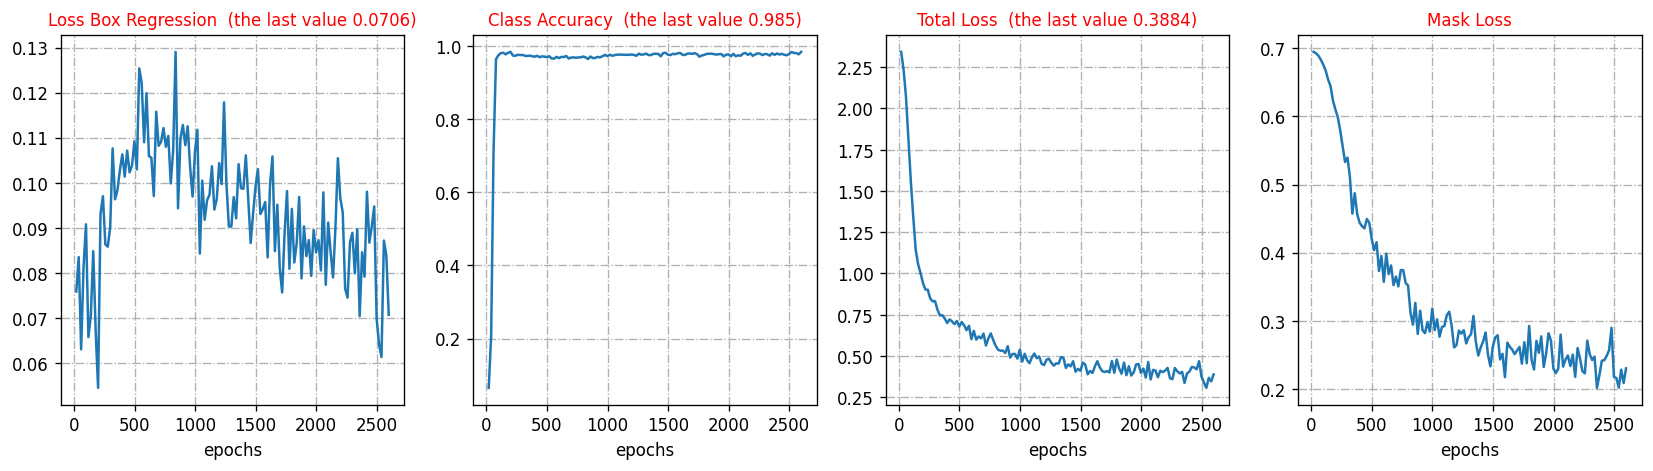

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)


axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, loss_mask)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('Mask Loss', fontsize = 10, color = 'red')

# Step 8: Model Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("brain_tumor_valid", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "brain_tumor_valid")
inference_on_dataset(trainer.model, test_loader, evaluator)

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("brain_tumor_valid")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("brain_tumor_valid")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (20,20), dpi = 120)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img[:, :, ::-1], metadata= dataset_metadata, scale=image_scale, instance_mode=ColorMode.IMAGE_BW)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 20)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 20, color = 'red')
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox[:, :, ::-1])

    fig.tight_layout()

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 421, image_scale = 1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 83, image_scale = 1)

# Step 9: Model Testing

#Step 10. Visualize the Model Architecture

fatal: not a git repository (or any of the parent directories): .git
